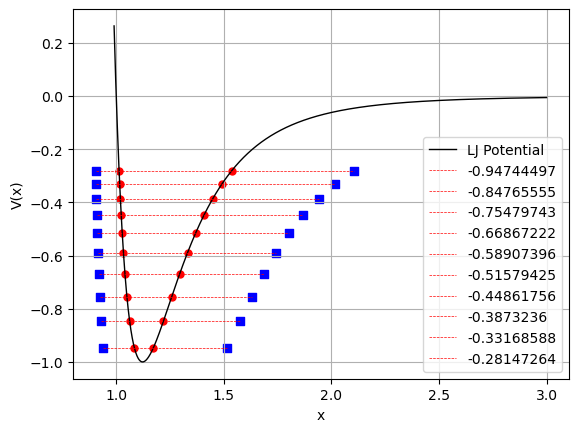

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

gamma = 50
alpha = 1e6

# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

# internal part of the Schrodinger eqn, in the Numerov general form y"(t) = g(t)y
def g(x):
    return gamma**2 * abs(v(x) - ek)






# ACTUAL CALCULATIONS START HERE
wkb_Energies = [
    -0.94744497,  # Energy at level 0
    -0.84765555,  # Energy at level 1
    -0.75479743,  # Energy at level 2
    -0.66867222,  # Energy at level 3
    -0.58907396,  # Energy at level 4
    -0.51579425,  # Energy at level 5
    -0.44861756,  # Energy at level 6
    -0.3873236,   # Energy at level 7
    -0.33168588,  # Energy at level 8
    -0.28147264   # Energy at level 9
]


# defining the x-grid
dx = 0.0001 
x = np.arange(0.99, 3, dx)
vx = [v(i) for i in x ]

plt.plot(x, vx,color='k', label="LJ Potential", linewidth = 1)
plt.xlabel("x")
plt.ylabel("V(x)")


for ek in wkb_Energies:

    """ Calculating the CTPs, root_scalar returns object with execulation results, unpacking needed for actual root """ 
    ctp_left = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.0, x1=1.0 + 1e-4)
    ctp_right = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.25, x1=1.25 + 1e-4)

    xa = ctp_left.root
    xb = ctp_right.root

    ## alternative mechanism for finding the CTPs : simplifies computations
    # for i in range(1, len(x)):
    #     if (vx[i-1]>ek and ek>vx[i]):
    #         ctpA = x[i]
    #     if (vx[i-1]<ek and ek<vx[i]):
    #         ctpB = x[i]      
    # ctpA, ctpB

    """Calculation of the integration limits for the wavefunction ODE"""
    # applying bisection method to calculate the start limit, xs
    # func: sqrt{g(xs)} (xa-xs) ln A
    xs = root_scalar(
        lambda x: np.sqrt(g(x)) * (xa - x) - np.log(alpha),
        bracket=[0.1,3],
        method='bisect',
    )
    # applying the same for end limit
    # func: sqrt{g(xe)} (xe-xb) ln A
    xe = root_scalar(
        lambda x: np.sqrt(g(x)) * (x - xb) - np.log(alpha),
        bracket=[0.1,3],
        method='bisect',
    )
    xs = xs.root #unpacking the root_scalar object
    xe = xe.root
    
    plt.scatter(xa, ek, marker="o", c='r', s=25)
    plt.scatter(xb, ek, marker="o",c='r', s=25 )
    plt.scatter(xs, ek, marker='s', color = 'b', s=30)
    plt.scatter(xe, ek, marker='s', color= 'b', s=30)
    plt.hlines(y=ek, xmin=xs, xmax=xe, color='r', linestyle='--', linewidth=0.5, label=f"{ek}")

plt.grid()
plt.legend()
